In [62]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [63]:
# names.txt contains a list of names
# We want to "train" a bigram name generation model on this dataset
# First, we read in the names
words = open('names.txt', 'r').read().splitlines()

# Inspect some of the names in the file
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [64]:
# We want to create a 2D array to store bigram counts
# Axes will be the alphabet, and the value of each cell will be the number of times that the bigram occurs
# We have 28 characters in our alphabet (a-z + {<S>, <E>})
b_arr = torch.zeros((27, 27), dtype=torch.int32)

In [65]:
# Now, we need a lookup table mapping characters to indices
alphabet = sorted(set(''.join(words)))
c_to_i = {}

# Dot will be a special character denoting the start or end of a string
# Give it value 0 in our character-to-index mapping
sp_char = '.'
c_to_i[sp_char] = 0

# Give other character a value starting at 1
for i, c in enumerate(alphabet):
    c_to_i[c] = i + 1

In [66]:
for w in words:
    # Create full list of characters, including start & end characters
    chs = [sp_char] + list(w) + [sp_char]

    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = c_to_i[ch1]
        ix2 = c_to_i[ch2]
        # Increment bigram count
        b_arr[ix1, ix2] += 1

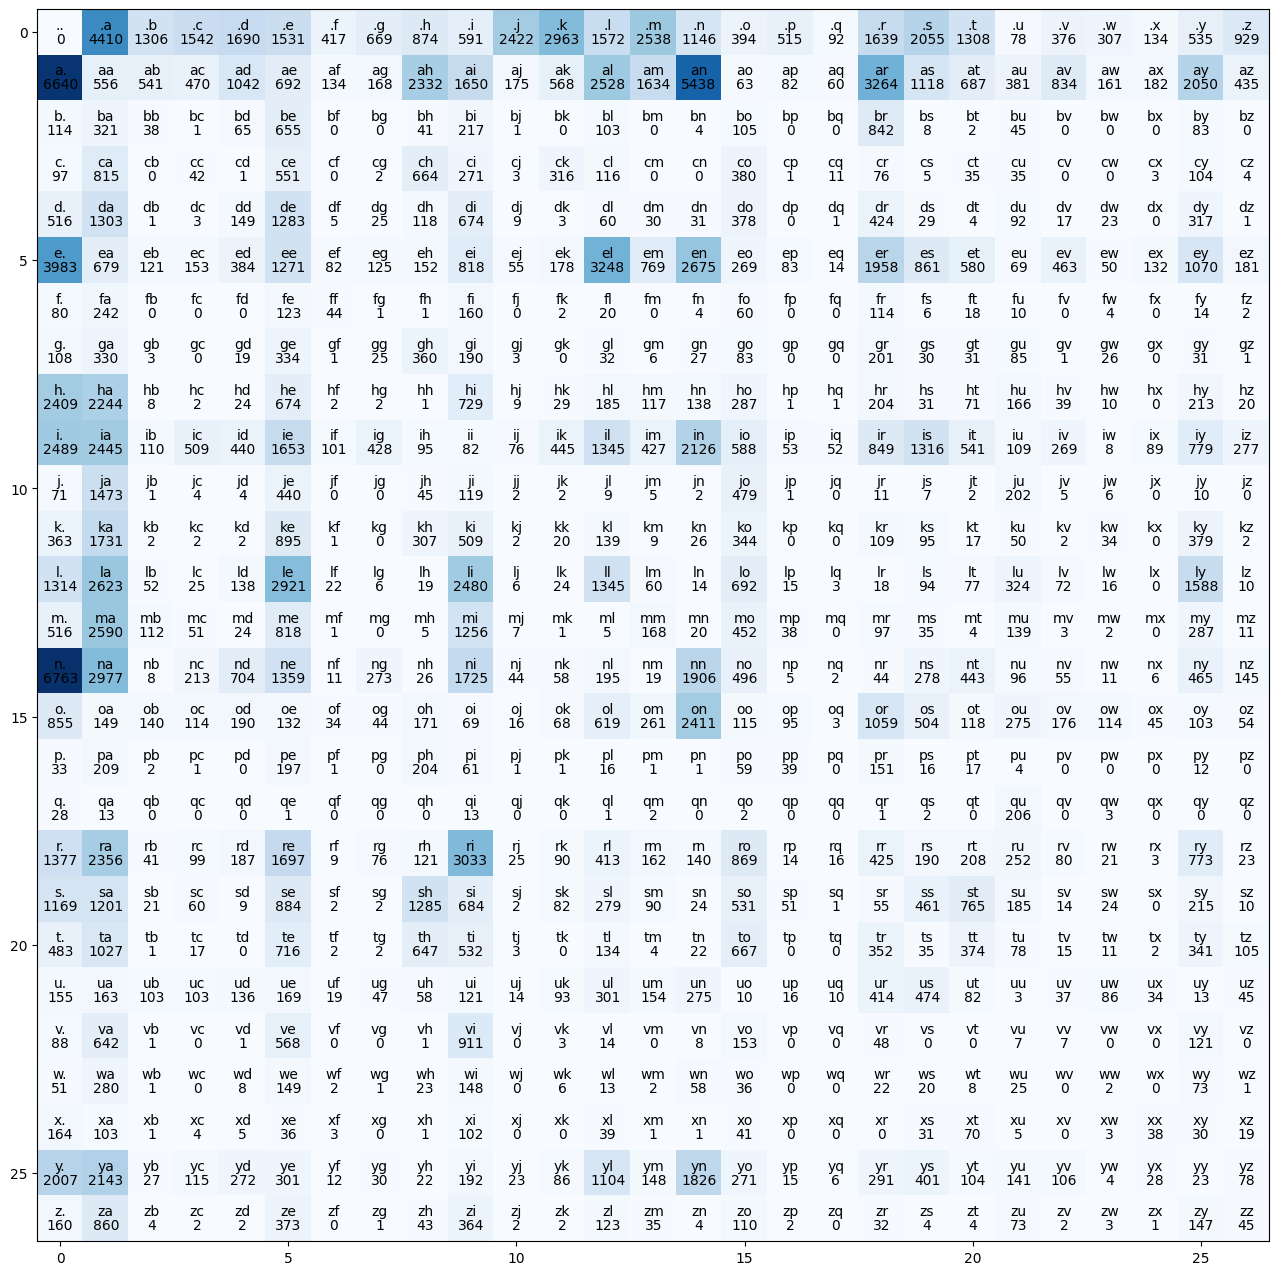

In [67]:
i_to_c = {i: c for c, i in c_to_i.items()}

# Visualize character pairs
plt.figure(figsize=(16, 16))
plt.imshow(b_arr, cmap='Blues')
for i in range(len(i_to_c)):
    for j in range(len(i_to_c)):
        bigram = i_to_c[i] + i_to_c[j]
        plt.text(j, i, bigram, ha='center', va='bottom')
        plt.text(j, i, b_arr[i, j].item(), ha='center', va='top')

In [68]:
# Get array of probabilities for each character
# Each row idx represents the character's position in the name
# I.e. row 0 represents the first character, row 1 represents the second character, etc.
# Therefore, we want to normalize across the rows for sampling
p_arr = b_arr.float() / b_arr.sum(1, keepdim=True)

In [115]:
# Generate 10 names
def generate_names(n, generator=None):
    if not generator:
        # Instantiate generator for sampling
        generator = torch.Generator().manual_seed(2147483647)

    for i in range(n):
        # List to store characters
        out = []

        ix = 0
        while True:
            # Get row of character probabilities
            p = p_arr[ix]
            # Sample from row
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
            # Get character
            out.append(i_to_c[ix])
            if ix == 0:
                break
        print(''.join(out))

In [116]:
generate_names(10)

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [100]:
# Create training set of bigrams
# xs will store first character in each bigram
# ys will store second character in each bigram
xs, ys = [], []

for w in words:
    # Create full list of characters, including start & end characters
    chs = [sp_char] + list(w) + [sp_char]

    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = c_to_i[ch1]
        ix2 = c_to_i[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print("Number of examples:", num)

Number of examples: 228146


In [106]:
# Build single-layer, 27-neuron neural network
# Each neuron recieves 27 inputs
g = torch.Generator().manual_seed(2147483647)

# Initialize random weight matrix
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [107]:
def forward_pass(xs):
    # One-hot encode xs
    xenc = F.one_hot(xs, num_classes=27).float()

    # Multiply weights to get "log counts"
    logits = xenc @ W #

    # Softmax logits to get probabilities
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    return probs


In [108]:
def negative_log_likelihood(xs, ys, i_to_c, probs):
    nlls = torch.zeros(len(xs))
    for i in range(len(xs)):
        x = xs[i].item() # Input character index
        y = ys[i].item() # Target character index

        print('----------------------')
        print(f'bigram example {i+1}: {i_to_c[x]}{i_to_c[y]} (indices {x}, {y})')
        print('input to neural net:', x)
        print('output probabilities from neural net:', probs[i])
        print('label (actual next character):', y)

        p = probs[i, y]
        print('probability assigned by the net to the correct next character:', p.item())

        logp = torch.log(p)
        print('log likelihood:', logp.item())

        nll = -logp
        print('negative log likelihood:', nll.item())
        nlls[i] = nll

    print('======================')
    print('average negative log likelihood:', nlls.mean().item())
    return nlls

In [109]:
def compute_loss(probs):
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    return loss

def backward_pass(loss, lr=0.1):
    W.grad = None
    loss.backward()
    W.data += -lr * W.grad
    return None

In [112]:
# Training loop
n_iter = 100
for i in range(n_iter):
    probs = forward_pass(xs)

    # Print out steps of negative log likelihood computation for debugging
    # _ = negative_log_likelihood(xs, ys, i_to_c, probs)

    loss = compute_loss(probs)
    print(loss.item())
    _ = backward_pass(loss, lr=50)

2.4726529121398926
2.4724340438842773
2.4722204208374023
2.472010850906372
2.4718058109283447
2.4716055393218994
2.4714086055755615
2.471216917037964
2.4710280895233154
2.470843553543091
2.4706625938415527
2.4704854488372803
2.4703118801116943
2.4701411724090576
2.4699742794036865
2.4698104858398438
2.4696500301361084
2.4694924354553223
2.4693377017974854
2.4691860675811768
2.4690372943878174
2.468890905380249
2.468747615814209
2.468606948852539
2.468468427658081
2.468332529067993
2.4681990146636963
2.4680681228637695
2.4679393768310547
2.4678127765655518
2.46768856048584
2.4675662517547607
2.4674463272094727
2.4673283100128174
2.467211961746216
2.467097759246826
2.4669854640960693
2.4668750762939453
2.466766595840454
2.4666597843170166
2.466554641723633
2.4664509296417236
2.4663491249084473
2.4662492275238037
2.4661505222320557
2.466053009033203
2.4659576416015625
2.4658637046813965
2.4657704830169678
2.46567964553833
2.4655895233154297
2.465500593185425
2.4654135704040527
2.465327262

In [120]:
def generate_names_with_nn(n, generator=None):
    if not generator:
        # Instantiate generator for sampling
        generator = torch.Generator().manual_seed(2147483647)

    for i in range(n):
        # List to store characters
        out = []

        ix = 0
        while True:
            # Encode characters
            xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
            logits = xenc @ W
            counts = logits.exp()
            p = counts / counts.sum(1, keepdims=True)
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
            # Get character
            out.append(i_to_c[ix])
            if ix == 0:
                break
        print(''.join(out))

In [121]:
generate_names_with_nn(10)

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
